In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Data/pseudo_facebook.csv")

In [3]:
df.tail()

,userid,age,dob_day,dob_year,dob_month,gender,tenure,friend_count,friendships_initiated,likes,likes_received,mobile_likes,mobile_likes_received,www_likes,www_likes_received
98998,1268299,68,4,1945,4,female,541.0,2118,341,3996,18089,3505,11887,491,6202
98999,1256153,18,12,1995,3,female,21.0,1968,1720,4401,13412,4399,10592,2,2820
99000,1195943,15,10,1998,5,female,111.0,2002,1524,11959,12554,11959,11462,0,1092
99001,1468023,23,11,1990,4,female,416.0,2560,185,4506,6516,4506,5760,0,756
99002,1397896,39,15,1974,5,female,397.0,2049,768,9410,12443,9410,9530,0,2913


In [4]:
categorical = ('gender')

In [5]:
df['gender'] = df['gender'].astype('category')

In [6]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [7]:
full_spans = get_spans(df, df.index)
full_spans

{'userid': 1193534,
 'age': 100,
 'dob_day': 30,
 'dob_year': 100,
 'dob_month': 11,
 'gender': 3,
 'tenure': 3139.0,
 'friend_count': 4923,
 'friendships_initiated': 4144,
 'likes': 25111,
 'likes_received': 261197,
 'mobile_likes': 25111,
 'mobile_likes_received': 138561,
 'www_likes': 14865,
 'www_likes_received': 129953}

In [8]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [9]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


In [10]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['friend_count', 'likes']
sensitive_column = 'age'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [11]:
# we get the number of partitions that were created
len(finished_partitions)

14700

In [12]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [13]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [14]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...
Finished 1601 partitions...
Finished 1701 partitions...
Finished 1801 partitions...
Finished 1901 partitions...
Finished 2001 partitions...
Finished 2101 partitions...
Finished 2201 partitions...
Finished 2301 partitions...
Finished 2401 partitions...
Finished 2501 partitions...
Finished 2601 partitions...
Finished 2701 partitions...
Finished 2801 partitions...
Finished 2901 partitions...
Finished 3001 partitions...
Finished 3101 partitions...
Finished 3201 partitions...
Finished 3301 partitions...
Finished 3401 partitions...
Finished 3501 partitions...
Fini

In [15]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
k_res=dfn.sort_values(feature_columns+[sensitive_column])
k_res

,friend_count,likes,age,count
0,0.00,0.092156,13,21
1,0.00,0.092156,14,44
2,0.00,0.092156,15,47
3,0.00,0.092156,16,42
4,0.00,0.092156,17,37
...,...,...,...,...
57564,4794.25,111.000000,33,1
50026,4870.25,8.500000,61,1
50027,4870.25,8.500000,66,1
50028,4870.25,8.500000,103,1


In [16]:
k_hidden_failure=0
for index, row in k_res.iterrows():
    if row['count']<3:
        k_hidden_failure=k_hidden_failure+row['count']
print(k_hidden_failure)

72228.0


In [40]:
import pandas as pd
ori = pd.read_csv("Data/pseudo_facebook.csv")
diff_out = pd.read_csv("Data/diff_out.csv")
diff_out

,userid,age,dob_day,dob_year,dob_month,gender,tenure,friend_count,friendships_initiated,likes,likes_received,mobile_likes,mobile_likes_received,www_likes,www_likes_received
0,2094382,18,19,1999,11,male,266.0,0,0,0,0,0,0,0,0
1,1192601,18,2,1999,11,female,6.0,0,0,0,0,0,0,0,0
2,2083884,18,16,1999,11,male,13.0,0,0,0,0,0,0,0,0
3,1203168,18,25,1999,12,female,93.0,0,0,0,0,0,0,0,0
4,1733186,18,4,1999,12,male,82.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98998,1268299,68,4,1945,4,female,541.0,2118,341,3996,18089,3505,11887,491,6202
98999,1256153,68,12,1995,3,female,21.0,1968,1720,4401,13412,4399,10592,2,2820
99000,1195943,91,10,1998,5,female,111.0,2002,1524,11959,12554,11959,11462,0,1092
99001,1468023,22,11,1990,4,female,416.0,2560,185,4506,6516,4506,5760,0,756


In [18]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

In [19]:
diff_df = dataframe_difference(ori, diff_out, 'both')
d_hidden_failure=0
for index, row in diff_df.iterrows():
    d_hidden_failure=d_hidden_failure+1
print(d_hidden_failure)

10006


In [20]:
dict = {}
i = 0
for index, row in k_res.iterrows():
    for x in range(int(row['count'])):
        dict[i] = {'friend_count' : row['friend_count'] , 'likes' : row['likes'], 'age' : row['age']} 
        i = i + 1
k_df = pd.DataFrame.from_dict(dict, "index")
k_df

,friend_count,likes,age
0,0.00,0.092156,13.0
1,0.00,0.092156,13.0
2,0.00,0.092156,13.0
3,0.00,0.092156,13.0
4,0.00,0.092156,13.0
...,...,...,...
98998,4794.25,111.000000,33.0
98999,4870.25,8.500000,61.0
99000,4870.25,8.500000,66.0
99001,4870.25,8.500000,103.0


In [31]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 3,
 n_jobs = -1)
o_normal = 0
o_total = 0
d_res=ori
d_res = d_res.drop(["dob_day", "dob_year", "dob_month"
                   , "gender", "tenure", "friendships_initiated"
                   , "likes_received", "mobile_likes", "mobile_likes_received"
                   , "www_likes", "www_likes_received", "userid"], axis=1)
clusters = outlier_detection.fit_predict(d_res)
for i in clusters:
    o_total = o_total + 1
    if i==-1:
        o_normal = o_normal + 1
print((o_total - o_normal) / o_total)
o_total
o_total - o_normal

0.17486338797814208


17312

In [28]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 3,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(k_df)
k_normal = 0
k_total = 0
for i in clusters:
    k_total = k_total + 1
    if i==-1:
        k_normal = k_normal + 1
print((k_total - k_normal) / k_total)
print(k_total)
print(k_normal)

0.2704463501106027
99003
72228


In [41]:
d_res=ori
d_res = d_res.drop(["dob_day", "dob_year", "dob_month"
                   , "gender", "tenure", "friendships_initiated"
                   , "likes_received", "mobile_likes", "mobile_likes_received"
                   , "www_likes", "www_likes_received", "userid"], axis=1)
d_res
diff_out = diff_out.drop(["dob_day", "dob_year", "dob_month"
                   , "gender", "tenure", "friendships_initiated"
                   , "likes_received", "mobile_likes", "mobile_likes_received"
                   , "www_likes", "www_likes_received", "userid"], axis=1)
diff_out

,age,friend_count,likes
0,18,0,0
1,18,0,0
2,18,0,0
3,18,0,0
4,18,0,0
...,...,...,...
98998,68,2118,3996
98999,68,1968,4401
99000,91,2002,11959
99001,22,2560,4506


In [37]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
 eps = .2, 
 metric="euclidean", 
 min_samples = 3,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(diff_out)
d_normal = 0
d_total = 0
for i in clusters:
    d_total = d_total + 1
    if i==-1:
        d_normal = d_normal + 1
print((d_total - d_normal) / d_total)
d_total - d_normal

0.41215922749815664


40805

In [24]:
list = []
for index, row in k_res.iterrows():
    for x in range(int(row['count'])):
        list.append(row['age'])
k_density = pd.Series(list)
ax = k_density.plot.kde()

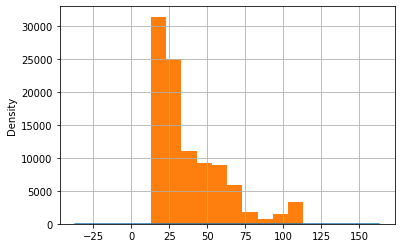

In [43]:
list = []
for index, row in d_res.iterrows():
    list.append(row['age'])
d_density = pd.Series(list)
ax = d_density.plot.kde()
d_xy = ax.get_lines()[0].get_xydata()
hist = d_density.hist(bins=10)

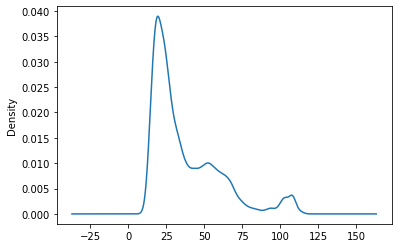

In [26]:
list = []
for index, row in ori.iterrows():
    list.append(row['age'])
o_density = pd.Series(list)
ax = o_density.plot.kde()
o_xy = ax.get_lines()[0].get_xydata()

In [27]:
step = o_xy[1][0] - o_xy[0][0]
d_ap = 0
for x in range(len(o_xy)):
    d_ap = d_ap + step * abs(o_xy[x][1] - d_xy[x][1])
print(d_ap)

0.0
